This code is for EN5423 class at GIST, Republic of Korea, and created by Dr. Hyunglok Kim.  
**Contact information**: hyunglokkim@gist.ac.kr  
**License**: This work is licensed for non-commercial use only.  
**Restrictions**: Do not use this material without permission for teaching or developing other classes.

In [12]:
import pandas as pd
import numpy as np
import pyreadr

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import rankdata, f
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from scipy.stats import kruskal
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.libqsturng import qsturng
import matplotlib.pyplot as plt

In [2]:
# Example 1: Iron at low flows—Two-actor permutation test.
# Path to the RDA file
file_path = './iron.rda'
# Reading the RDA file
result = pyreadr.read_r(file_path)
data_iron = result['iron']

In [3]:
data_iron

,Fe,Mining,Rocktype,Group
0,0.200000,Unmined,Limestone,lime_un
1,0.250000,Unmined,Limestone,lime_un
2,0.040000,Unmined,Limestone,lime_un
3,0.060000,Unmined,Limestone,lime_un
4,1.200000,Unmined,Limestone,lime_un
...,...,...,...,...
73,11.999998,Reclaimed,Sandstone,sand_re
74,0.600000,Reclaimed,Sandstone,sand_re
75,13.999998,Reclaimed,Sandstone,sand_re
76,0.810000,Reclaimed,Sandstone,sand_re


In [4]:
data = pd.DataFrame({
    'fe': data_iron.Fe,  # iron concentration
    'mining': data_iron.Mining,
    'rocktype': data_iron.Rocktype
})

# Define the function for calculating F-statistic
def calculate_f_statistic(data, factor1, factor2, response):
    model = ols(f'{response} ~ {factor1}*{factor2}', data=data).fit()
    anova_results = sm.stats.anova_lm(model, typ=2)
    return anova_results['F']

# Function to perform the permutation test
def two_factor_permutation_test(data, factor1, factor2, response, num_permutations=100):
    observed_f_stat = calculate_f_statistic(data, factor1, factor2, response)
    
    def permuted_stat():
        permuted_data = data.copy()
        permuted_data[response] = np.random.permutation(permuted_data[response].values)
        return calculate_f_statistic(permuted_data, factor1, factor2, response)
    
    perm_stats = np.array([permuted_stat() for _ in range(num_permutations)])
    
    p_values = {
        factor1: np.mean(perm_stats[:, 0] >= observed_f_stat.iloc[0]),
        factor2: np.mean(perm_stats[:, 1] >= observed_f_stat.iloc[1]),
        f'{factor1}:{factor2}': np.mean(perm_stats[:, 2] >= observed_f_stat.iloc[2])
    }
    
    return observed_f_stat, p_values

# Perform the test
observed_f_stat, p_values = two_factor_permutation_test(data, 'mining', 'rocktype', 'fe', num_permutations=5000)

print("Observed F-statistics:", observed_f_stat)
print("P-values:", p_values)

Observed F-statistics: mining             2.492636
rocktype           2.379906
mining:rocktype    1.997428
Residual                NaN
Name: F, dtype: float64
P-values: {'mining': 0.0, 'rocktype': 0.0096, 'mining:rocktype': 0.0316}


In [22]:
# Example 2: Iron at low flows—Two-actor BDM test.
data = pd.DataFrame({
    'fe': data_iron.Fe,  # iron concentration
    'mining': data_iron.Mining,
    'rocktype': data_iron.Rocktype
})

# Calculate ranks for the response variable
data['fe_rank'] = rankdata(data['fe'])

# Fit the OLS model on ranks
model = ols('fe_rank ~ mining * rocktype', data=data).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Extract sum of squares and degrees of freedom
SS = anova_results['sum_sq']
df = anova_results['df']

# Calculate mean squares
MS = SS / df

# Calculate the F* statistics
MS_error = MS.iloc[-1]
F_star = MS / MS_error

# Calculate the adjusted degrees of freedom for the BDM test
n = len(data)  # total number of observations
p = len(model.params)  # number of parameters (including intercept)

def adjusted_df(n, df1, df2):
    """Calculate the adjusted degrees of freedom for the BDM test."""
    numerator = (n - df1) * df2
    denominator = df1 + df2 - 1
    return numerator / denominator if denominator != 0 else float('inf')

# Adjusted degrees of freedom for each term
df2_adjusted = [adjusted_df(n, df.iloc[i], df.iloc[-1]) for i in range(len(df) - 1)]
df2_adjusted.append(df.iloc[-1])  # Add the residual degrees of freedom without adjustment

# Calculate the P(F > F*)
p_values = [1 - f.cdf(F_star.iloc[i], df.iloc[i], df2_adjusted[i]) for i in range(len(F_star))]

# Print the results
results = pd.DataFrame({
    'df1': df,
    'df2': df2_adjusted,
    'F*': F_star,
    'P(F > F*)': p_values
})

print(results)

                  df1        df2         F*     P(F > F*)
mining            2.0  74.958904  17.740921  4.920162e-07
rocktype          1.0  77.000000  13.375242  4.642748e-04
mining:rocktype   2.0  74.958904   3.709541  2.909338e-02
Residual         72.0  72.000000   1.000000  5.000000e-01


In [24]:
file_path = './specapic.rda'
# Reading the RDA file
result = pyreadr.read_r(file_path)
data = result['specapic']
data

,spcap,rock
0,132.993439,Dolomite
1,8.679813,Dolomite
2,1.550070,Dolomite
3,0.600015,Dolomite
4,4.659928,Dolomite
...,...,...
195,0.299992,Siliciclastic
196,0.029999,Siliciclastic
197,0.919983,Siliciclastic
198,0.249999,Siliciclastic


In [34]:
# Example 1: Iron at low flows—Two-actor permutation test.
# Path to the RDA file
file_path = './iron.rda'
# Reading the RDA file
result = pyreadr.read_r(file_path)
data_iron = result['iron']

,Fe,Mining,Rocktype,Group
0,0.200000,Unmined,Limestone,lime_un
1,0.250000,Unmined,Limestone,lime_un
2,0.040000,Unmined,Limestone,lime_un
3,0.060000,Unmined,Limestone,lime_un
4,1.200000,Unmined,Limestone,lime_un
...,...,...,...,...
73,11.999998,Reclaimed,Sandstone,sand_re
74,0.600000,Reclaimed,Sandstone,sand_re
75,13.999998,Reclaimed,Sandstone,sand_re
76,0.810000,Reclaimed,Sandstone,sand_re


              sum_sq     df         F    PR(>F)
rock       54.029544    3.0  4.191556  0.006671
Residual  842.152621  196.0       NaN       NaN
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
   Dolomite     Limestone  -1.0964 0.0435 -2.1706 -0.0222   True
   Dolomite   Metamorphic  -1.3018 0.0104  -2.376 -0.2275   True
   Dolomite Siliciclastic  -1.1663 0.0275 -2.2406 -0.0921   True
  Limestone   Metamorphic  -0.2053 0.9601 -1.2796  0.8689  False
  Limestone Siliciclastic  -0.0699 0.9983 -1.1441  1.0043  False
Metamorphic Siliciclastic   0.1354 0.9879 -0.9388  1.2097  False
----------------------------------------------------------------


<Figure size 1000x600 with 0 Axes>

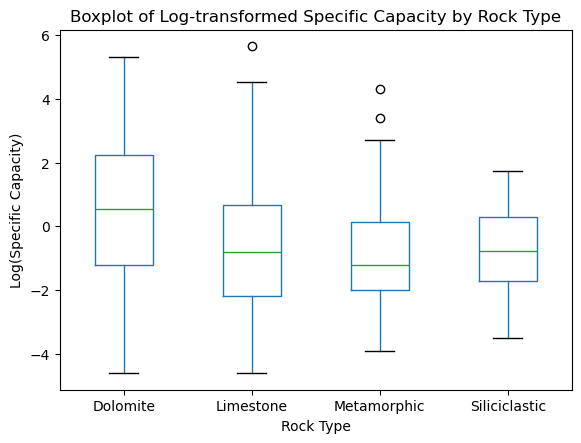

In [40]:
# Example 3: Specific capacity—Tukey’s multiple comparison test.
# Path to the RDA file
file_path = './specapic.rda'
# Reading the RDA file
result = pyreadr.read_r(file_path)
data = result['specapic']

df = pd.DataFrame(data)

# Log-transform the specific capacity data
df['log_spcap'] = np.log(df['spcap'])

# Perform ANOVA
model = ols('log_spcap ~ rock', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['log_spcap'], groups=df['rock'], alpha=0.05)
print(tukey)

# Boxplot of the natural logs of the data
plt.figure(figsize=(10, 6))
df.boxplot(column='log_spcap', by='rock', grid=False)
plt.title('Boxplot of Log-transformed Specific Capacity by Rock Type')
plt.suptitle('')
plt.xlabel('Rock Type')
plt.ylabel('Log(Specific Capacity)')
plt.show()

In [45]:
# Example 4: Specific capacity—Nonparametric multiple comparisons.

# Path to the RDA file
file_path = './specapic.rda'
# Reading the RDA file
result = pyreadr.read_r(file_path)
data = result['specapic']

df = pd.DataFrame(data)

# Perform pairwise Wilcoxon rank-sum tests
pairwise_comparisons = []
groups = df['rock'].unique()
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = df[df['rock'] == groups[i]]['spcap']
        group2 = df[df['rock'] == groups[j]]['spcap']
        stat, p_value = ranksums(group1, group2)
        pairwise_comparisons.append((groups[i], groups[j], p_value))

# Adjust p-values using BH method
p_values = [comp[2] for comp in pairwise_comparisons]
_, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh')

# Display results
results = []
for k, (group1, group2, _) in enumerate(pairwise_comparisons):
    results.append({'Comparison': f'{group1} vs {group2}', 'Adjusted p-value': p_adjusted[k]})

results_df = pd.DataFrame(results)
print(results_df)

                     Comparison  Adjusted p-value
0         Dolomite vs Limestone          0.042610
1       Dolomite vs Metamorphic          0.012399
2     Dolomite vs Siliciclastic          0.012399
3      Limestone vs Metamorphic          0.802891
4    Limestone vs Siliciclastic          0.893063
5  Metamorphic vs Siliciclastic          0.586106


In [51]:
# Perform Kruskal-Wallis test
groups = [df[df['rock'] == group]['spcap'].values for group in df['rock'].unique()]
stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test p-value: {p_value}')

# Perform Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn(df, val_col='spcap', group_col='rock', p_adjust='bonferroni')

# Suppressing FutureWarnings by modifying the groupby calls in scikit-posthocs
def custom_posthoc_dunn(x, val_col, group_col, p_adjust=None):
    x = x[[val_col, group_col]].copy()
    x['ranks'] = x[val_col].rank()
    x_lens = x.groupby(group_col, observed=False)[val_col].count()
    x_ranks_avg = x.groupby(group_col, observed=False)['ranks'].mean()
    # Rest of the function as in the original scikit-posthocs

# Print the results
print(dunn_results)

Kruskal-Wallis test p-value: 0.009120337563584973
               Dolomite  Limestone  Metamorphic  Siliciclastic
Dolomite       1.000000   0.065852     0.011381       0.072482
Limestone      0.065852   1.000000     1.000000       1.000000
Metamorphic    0.011381   1.000000     1.000000       1.000000
Siliciclastic  0.072482   1.000000     1.000000       1.000000


/opt/homebrew/Caskroom/miniforge/base/envs/hydroai/lib/python3.12/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/opt/homebrew/Caskroom/miniforge/base/envs/hydroai/lib/python3.12/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


In [53]:
# Perform Kruskal-Wallis test with BH adjusted
groups = [df[df['rock'] == group]['spcap'].values for group in df['rock'].unique()]
stat, p_value = kruskal(*groups)
print(f'Kruskal-Wallis test p-value: {p_value}')

# Perform Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn(df, val_col='spcap', group_col='rock', p_adjust='fdr_bh')

# Suppressing FutureWarnings by modifying the groupby calls in scikit-posthocs
def custom_posthoc_dunn(x, val_col, group_col, p_adjust=None):
    x = x[[val_col, group_col]].copy()
    x['ranks'] = x[val_col].rank()
    x_lens = x.groupby(group_col, observed=False)[val_col].count()
    x_ranks_avg = x.groupby(group_col, observed=False)['ranks'].mean()
    # Rest of the function as in the original scikit-posthocs

# Print the results
print(dunn_results)

Kruskal-Wallis test p-value: 0.009120337563584973
               Dolomite  Limestone  Metamorphic  Siliciclastic
Dolomite       1.000000   0.024161     0.011381       0.024161
Limestone      0.024161   1.000000     0.688584       0.973121
Metamorphic    0.011381   0.688584     1.000000       0.688584
Siliciclastic  0.024161   0.973121     0.688584       1.000000


/opt/homebrew/Caskroom/miniforge/base/envs/hydroai/lib/python3.12/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/opt/homebrew/Caskroom/miniforge/base/envs/hydroai/lib/python3.12/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


In [3]:
# Example 5: Numerical example to illustrate Tukey’s MCT
# Adjusted data
data = {
    'Treatment': ['A1', 'A1', 'A2', 'A2', 'A3', 'A3'],
    'Adjusted Growth Rate': [-1.0, -1.0, 0.0, 0.0, 1.0, 1.0]
}

df = pd.DataFrame(data)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['Adjusted Growth Rate'], groups=df['Treatment'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower upper reject
-----------------------------------------------
    A1     A2      1.0   0.0   1.0   1.0   True
    A1     A3      2.0   0.0   2.0   2.0   True
    A2     A3      1.0   0.0   1.0   1.0   True
-----------------------------------------------


/opt/homebrew/Caskroom/miniforge/base/envs/hydroai/lib/python3.12/site-packages/statsmodels/sandbox/stats/multicomp.py:1300: RuntimeWarning: divide by zero encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


In [26]:
# Example 6: . Iron at low flows—Tukey’s multiple comparisons for two-factor ANOVA.
# Path to the RDA file
file_path = './iron.rda'
# Reading the RDA file
result = pyreadr.read_r(file_path)
data_iron = result['iron']
data_iron['log_Fe'] = np.log(data_iron['Fe'])

print(data_iron)
# Perform two-factor ANOVA
model = ols('log_Fe ~ Mining * Rocktype', data=data_iron).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform Tukey's HSD test for the primary factor of interest (Mining)
tukey_result = pairwise_tukeyhsd(endog=data_iron['log_Fe'], groups=data_iron['Mining'], alpha=0.05)
print(tukey_result)

           Fe     Mining   Rocktype    Group    log_Fe
0    0.200000    Unmined  Limestone  lime_un -1.609438
1    0.250000    Unmined  Limestone  lime_un -1.386294
2    0.040000    Unmined  Limestone  lime_un -3.218876
3    0.060000    Unmined  Limestone  lime_un -2.813411
4    1.200000    Unmined  Limestone  lime_un  0.182321
..        ...        ...        ...      ...       ...
73  11.999998  Reclaimed  Sandstone  sand_re  2.484906
74   0.600000  Reclaimed  Sandstone  sand_re -0.510826
75  13.999998  Reclaimed  Sandstone  sand_re  2.639057
76   0.810000  Reclaimed  Sandstone  sand_re -0.210721
77   0.980000  Reclaimed  Sandstone  sand_re -0.020203

[78 rows x 5 columns]
                     sum_sq    df          F    PR(>F)
Mining            69.746910   2.0  15.890508  0.000002
Rocktype          26.312445   1.0  11.989581  0.000904
Mining:Rocktype    2.441812   2.0   0.556320  0.575759
Residual         158.011862  72.0        NaN       NaN
   Multiple Comparison of Means - Tukey HS

In [22]:
ssw = 158.011862  # Residual Sum of Squares
dfw = 72  # Degrees of Freedom for Residual
print(data_iron['Mining'].value_counts())
n = 26  # Number of observations per group

alpha = 0.05  # Significance level
k = 3  # Number of groups

# Compute MSE
mse = ssw / dfw

# Critical value Q from the studentized range distribution
# For 6 groups, 72 df, alpha = 0.05
q_critical = qsturng(1 - alpha, k, dfw)

# Compute LSR
lsr = q_critical * np.sqrt(mse / n)
print(f'Least Significant Range (LSR): {lsr:.4f}')

Mining
Abandoned    26
Reclaimed    26
Unmined      26
Name: count, dtype: int64
Least Significant Range (LSR): 0.9833


In [28]:
# Example 7: Iron at low flows—Factorial pairwise rank-sum tests.
# Path to the RDA file
file_path = './iron.rda'
# Reading the RDA file
result = pyreadr.read_r(file_path)
data_iron = result['iron']

# Compute a numeric group indicator for rocktype
data_iron['Gpind'] = 1 + (data_iron['Rocktype'] == 'Sandstone').astype(int)

# Compute median iron concentrations for each rocktype
rock_medians = data_iron.groupby('Gpind')['Fe'].median().to_dict()

# Subtract the medians from the iron concentrations to produce the adjusted iron concentrations
data_iron['feadj'] = data_iron.apply(lambda row: row['Fe'] - rock_medians[row['Gpind']], axis=1)

# Convert unique mining levels to a list and sort them
mining_levels = sorted(data_iron['Mining'].unique())

# Perform pairwise Wilcoxon rank-sum tests on the adjusted iron concentrations for the primary factor (Mining)
pairwise_results = []

for i in range(len(mining_levels)):
    for j in range(i + 1, len(mining_levels)):
        group1 = data_iron[data_iron['Mining'] == mining_levels[i]]['feadj']
        group2 = data_iron[data_iron['Mining'] == mining_levels[j]]['feadj']
        stat, p_value = ranksums(group1, group2)
        pairwise_results.append({
            'Group 1': mining_levels[i],
            'Group 2': mining_levels[j],
            'Statistic': stat,
            'p-value': p_value
        })

# Display the results of the pairwise Wilcoxon rank-sum tests
pairwise_results_df = pd.DataFrame(pairwise_results)
print(pairwise_results_df)

# Calculate relative effects
data_iron['rank'] = data_iron['feadj'].rank()
relative_effects = data_iron.groupby('Mining')['rank'].mean() / len(data_iron)
relative_effects = relative_effects.sort_values(ascending=False).reset_index()
relative_effects.columns = ['Mining', 'Rel.effects']

print(relative_effects)

     Group 1    Group 2  Statistic   p-value
0  Abandoned  Reclaimed   2.415757  0.015703
1  Abandoned    Unmined   4.117768  0.000038
2  Reclaimed    Unmined   2.937341  0.003310
      Mining  Rel.effects
0  Abandoned     0.682446
1  Reclaimed     0.520464
2    Unmined     0.316321


/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_1496/3244221211.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  relative_effects = data_iron.groupby('Mining')['rank'].mean() / len(data_iron)


In [29]:
# Perform pairwise Wilcoxon rank-sum tests on the adjusted iron concentrations for the primary factor (Mining)
pairwise_results = []
p_values = []

for i in range(len(mining_levels)):
    for j in range(i + 1, len(mining_levels)):
        group1 = data_iron[data_iron['Mining'] == mining_levels[i]]['feadj']
        group2 = data_iron[data_iron['Mining'] == mining_levels[j]]['feadj']
        stat, p_value = ranksums(group1, group2)
        pairwise_results.append({
            'Group 1': mining_levels[i],
            'Group 2': mining_levels[j],
            'Statistic': stat,
            'p-value': p_value
        })
        p_values.append(p_value)

# Adjust p-values for multiple comparisons using the Benjamini-Hochberg (BH) procedure
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# Add the adjusted p-values to the results
for i in range(len(pairwise_results)):
    pairwise_results[i]['p-adj'] = pvals_corrected[i]
    pairwise_results[i]['reject'] = reject[i]

# Display the results of the pairwise Wilcoxon rank-sum tests with adjusted p-values
pairwise_results_df = pd.DataFrame(pairwise_results)
print(pairwise_results_df)

# Calculate relative effects
data_iron['rank'] = data_iron['feadj'].rank()
relative_effects = data_iron.groupby('Mining')['rank'].mean() / len(data_iron)
relative_effects = relative_effects.sort_values(ascending=False).reset_index()
relative_effects.columns = ['Mining', 'Rel.effects']

print(relative_effects)

     Group 1    Group 2  Statistic   p-value     p-adj  reject
0  Abandoned  Reclaimed   2.415757  0.015703  0.015703    True
1  Abandoned    Unmined   4.117768  0.000038  0.000115    True
2  Reclaimed    Unmined   2.937341  0.003310  0.004966    True
      Mining  Rel.effects
0  Abandoned     0.682446
1  Reclaimed     0.520464
2    Unmined     0.316321


/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_1496/3672519900.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  relative_effects = data_iron.groupby('Mining')['rank'].mean() / len(data_iron)
